In [671]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.stats import mode
from sklearn import linear_model
import matplotlib
import matplotlib.pyplot as plt
from sklearn import discriminant_analysis
from sklearn.decomposition import PCA
from sklearn import preprocessing
%matplotlib inline
from datetime import datetime
from sklearn.preprocessing import PolynomialFeatures
import seaborn

### Building our Sentiment Model

The goal of our project being to analyze if sentiment analysis can improve our model. To see if adding sentiment analysis will improve our ability to predict consumer sentiment, we will create a new model which follows the same modeling process as our baseline model. The only difference is tat now we will be including sentiment analysis data from New York Times Articles as a feature. The rationale for this is that if we use the same process and the only change is the addition of sentiment data, then any increase in accuracy of our model can be attributed to sentiment data, and we can conclude that sentiment analysis does help predict consumer sentiment. 


### Sentiment Analysis and Data Processing
After collecting years worth of New York Times headlines and sentiment analysis data, we first have to read all our csvs that contain the sentiment data. Then we have to standarize all our values. Because certain months had more articles written that month, it is very possible that certain months were just more prolific times for the New York Times. As a result, we want to average sentiment scores. Similar to other economic data, we will use the lag values for sentiment as well, as well as include the cocurrent data because the articles are released before the sentiment scores. 


In [672]:
#Extract the MCI Data
years = list(range(1982, 2017))
sa_scores = pd.DataFrame()
for year in years:
    
    #Input file
    filename = 'sentiment_scores/SA_scores_' + str(year) + '.csv'
    scores = pd.read_csv(filename)
    
    #Create positive_standard, neutral_standard, and positive
    if len(scores.columns) == 4:
        scores['positive'] = scores['pos']
        scores['positive_standard'] = scores['pos']*1.0/scores['count']
        scores['neutral_standard'] = scores['neutral']*1.0/scores['count']
    
    sa_scores = pd.concat([sa_scores, scores], axis = 0)
sa_scores = sa_scores.drop(sa_scores.columns[[0,1,4]], axis = 1)
sa_scores = sa_scores[['positive', 'positive_standard', 'neutral', 'neutral_standard']]

In [673]:
#Get the differences for our sentiment scores
pos = sa_scores['positive'].values
pos = np.diff(pos, axis=0)
pos_stand = sa_scores['positive_standard'].values
pos_stand = np.diff(pos_stand, axis = 0)
neutral = sa_scores['neutral'].values
neutral = np.diff(neutral, axis = 0)
neutral_stand = sa_scores['neutral_standard'].values
neutral_stand = np.diff(neutral_stand, axis = 0)

In [674]:
collective_data = pd.read_csv('datasets/collective_data.csv')
#Extract mci data
mci_data = collective_data.iloc[:,6:7].values
mci = np.diff(mci_data, axis=0)

In [675]:
#Create functions for lags
def add_lags(data):
    data_lags = pd.concat([data.shift(i) for i in range(0, 13)], axis = 1)
    return data_lags
def add_lags_after(data):
    data_lags = pd.concat([data.shift(i) for i in range(1, 13)], axis = 1)
    return data_lags
def add_lags_gdp(data):
    data_lags = pd.concat([data.shift(3), data.shift(6), data.shift(9), data.shift(12)], axis = 1)
    return data_lags

In [676]:
mci = pd.DataFrame(mci)
pos = pd.DataFrame(pos)
pos_stand = pd.DataFrame(pos_stand)
neutral = pd.DataFrame(neutral)
neutral_stand = pd.DataFrame(neutral_stand)
date = collective_data.iloc[:,0:1]
pce = collective_data.iloc[:,1:2]
gdp = collective_data.iloc[:,2:3]
ur = collective_data.iloc[:,3:4]
m2 = collective_data.iloc[:,4:5]
jobless = collective_data.iloc[:,5:6]

pos_lags = add_lags(pos)
pos_stand_lags = add_lags(pos_stand)
neutral_lags = add_lags(neutral)
neutral_stand_lags = add_lags(neutral_stand)
pce_lags = add_lags_after(pce)
gdp_lags = add_lags_gdp(gdp)
ur_lags = add_lags_after(ur)
m2_lags = add_lags(m2)
jobless_lags = add_lags(jobless)
mci_lags = add_lags_after(mci)

all_data = pd.concat([date, gdp_lags, ur_lags, m2_lags, jobless_lags, mci_lags, mci], axis=1)

In [677]:
all_data = pd.concat([all_data, pos_stand_lags, neutral_stand_lags], axis = 1)

In [679]:
all_data = all_data.drop(all_data.columns[[0,1]], axis = 1)

In [680]:
#Split our data into train and test
train = np.diff(all_data.iloc[60:380,:].values, axis = 0)
test = np.diff(all_data.iloc[380:464,:].values, axis = 0)
x_train = np.diff(all_data.iloc[60:380,:-1].values, axis = 0)
y_train = np.diff(all_data.iloc[60:380,-1].values, axis = 0)
x_test = np.diff(all_data.iloc[380:464,:-1], axis = 0)
y_test = np.diff(all_data.iloc[380:464,-1], axis = 0)

In [681]:
##create a boostrap function to cross validate the best c value for Lasso
#The idea is that the purpose of our test is to predict future values
#as a result, instead of using k fold cv, which will choose each fold as a test data, we will randomly sample
#sequences of data within our training data and then score them
#we will do this for a variety of c values and see how to fix it
import random

def boot_lasso(x, y):
    avg_acc = []
    n = x.shape[0]
    for i in range(-7, 8):
        k = 10**i
        acc = 0
        for j in range(0,10):
            m = random.randint(0,n-245)
            x_train = x[m:m+200]
            y_train = y[m:m+200]
            x_test = x[m+200:m+244]
            y_test = y[m+200:m+244]
            lasso = linear_model.Lasso(alpha = k)
            lasso.fit(x_train, y_train)
            score = lasso.score(x_test, y_test)
            acc += score
        avg_acc.append(acc/10)
    return np.argmax(avg_acc) -7, avg_acc
        

In [682]:
best_alpha, scores = boot_lasso(x_train, y_train)

In [683]:
lasso = linear_model.Lasso(alpha = 10**best_alpha)
lasso.fit(x_train, y_train)
lasso_coefs = lasso.coef_
coef_lst = []
for i in range(0, len(lasso_coefs)):
    if (lasso_coefs[i] == 0):
        coef_lst.append(i)

In [684]:
new_data = all_data.drop(all_data.columns[coef_lst], axis = 1)

In [703]:
#Split our data into train and test
train = np.diff(new_data.iloc[60:396,:].values, axis = 0)
test = np.diff(new_data.iloc[396:464,:].values, axis = 0)
x_train = np.diff(new_data.iloc[60:340,:-1].values, axis = 0)
y_train = np.diff(new_data.iloc[60:340,-1].values, axis = 0)
x_test = np.diff(new_data.iloc[340:464,:-1], axis = 0)
y_test = np.diff(new_data.iloc[340:464,-1], axis = 0)

In [720]:
##create a boostrap function to cross validate the best c value for Lasso
#The idea is that the purpose of our test is to predict future values
#as a result, instead of using k fold cv, which will choose each fold as a test data, we will randomly sample
#sequences of data within our training data and then score them
#we will do this for a variety of c values and see how to fix it
import random

def boot_ridge(x, y):
    avg_acc = []
    n = x.shape[0]
    for i in range(-7, 8):
        k = 10**i
        acc = 0
        for j in range(0,10):
            m = random.randint(0,n-245)
            x_train = x[m:m+200]
            y_train = y[m:m+200]
            x_test = x[m+200:m+244]
            y_test = y[m+200:m+244]
            ridge = linear_model.Ridge(alpha = k)
            ridge.fit(x_train, y_train)
            score = ridge.score(x_test, y_test)
            acc += score
        avg_acc.append(acc/10)
    return np.argmax(avg_acc) -7, avg_acc
        

In [721]:
best_a, scores = boot_ridge(x_train, y_train)

In [722]:
ridge = linear_model.Ridge(alpha = best_a)
ridge.fit(x_train, y_train)
diffdiff_pred = ridge.predict(x_test)
score = ridge.score(x_test, y_test)

In [752]:
print 'The score for our sentiment model is ' + str(score)

The score for our sentiment model is 0.482475923545


### Results

After running our sentiment model, we see that the R^2 value of our model increased to .4824. 

In [773]:
m = mci_data[341:464]
m = m.ravel()

In [774]:
len(m)

123

In [798]:
diff = mci[341:464].values
diff = diff.ravel()
d = mci[340:464].values
d = d.ravel()

In [799]:
diffdiff = np.diff(d, axis=0)

In [807]:
h = pd.DataFrame({'m':m, 'diff':diff, 'diffdiff': diffdiff, 'diffdiff_pred':diffdiff_pred, 'mci_pred':mci_pred})

In [809]:
residuals = diffdiff - diffdiff_pred

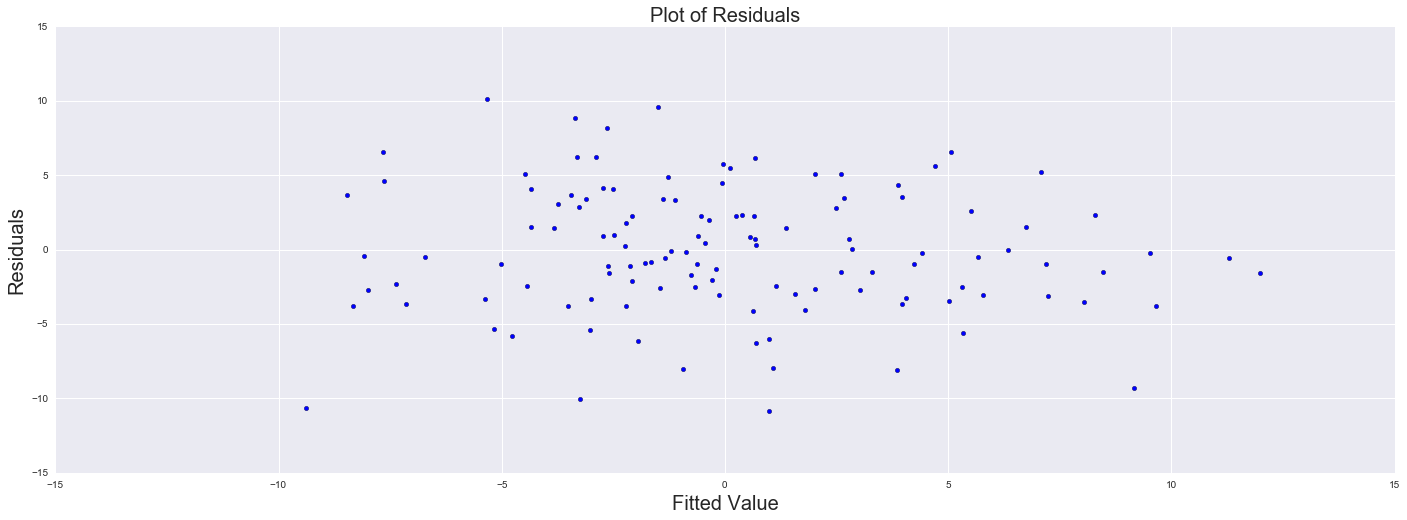

In [819]:
fig, ax = plt.subplots(figsize=(24,8))
ax.scatter(diffdiff_pred, residuals)
ax.set_xlabel('Fitted Value', fontsize = 20)
ax.set_ylabel('Residuals', fontsize = 20)
ax.set_title('Plot of Residuals', fontsize = 20)
plt.show()

In [805]:
mci_pred = []
for i in range(1, len(diffdiff_pred)):
    d = diffdiff_pred[i] + diff[i-1]
    pred = m[i-1] + d
    mci_pred.append(pred)
mci_pred.append(1)

In [759]:
print len(m)

123


In [770]:
print len(mci_pred)
rm = m[0:122]
print len(rm)

122
122


In [761]:
dat = date[343:496].values
date_lst = []
for i in range(0, dat.shape[0]):
    u = str(dat[i])
    u = u.replace(',', '')
    u = u.replace("'", '')
    u = u.replace('[', '')
    u = u.replace(']', '')
    u = datetime.strptime(u, '%d-%b-%y')
    date_lst.append(u)

ValueError: x and y must have same first dimension

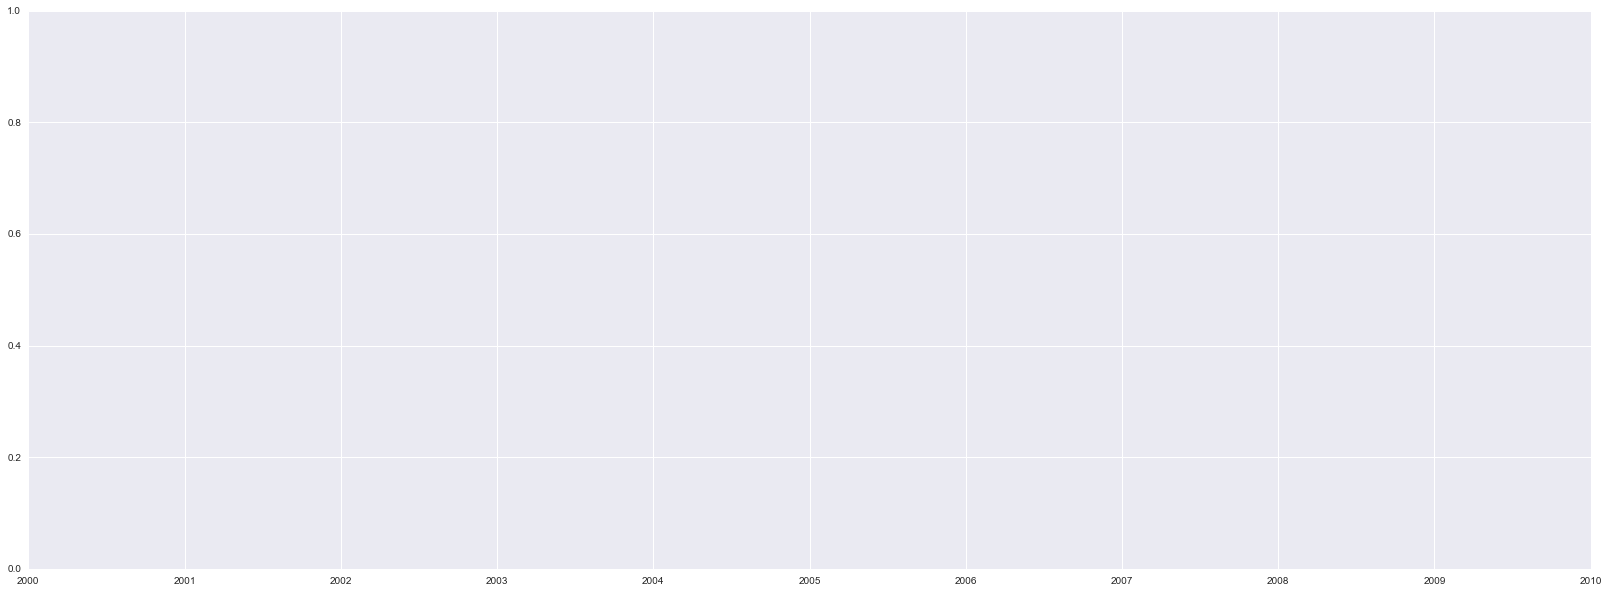

In [817]:
# plt.figure(figsize=(18,5))
# pred, = plt.plot(date_lst, mci_pred, c='green')
# real, = plt.plot(date_lst, rm, c='blue')


# plt.legend((pred, real), ('Predicted MCI', "Real MCI"))

# plt.ylabel("MCI Scores", fontsize = 20)
# plt.suptitle('Sentiment Modeling Results')
# plt.show()

fig, ax = plt.subplots(figsize=(28,10))
pred, = ax.plot(date_lst, mci_pred, c='green')
real, = ax.plot(date_lst, rm, c='blue')
ax.set_ylabel("MCI Score", fontsize = 20)
ax.set_title("Sentiment Modeling", fontsize = 20)
ax.legend((pred, real), ('Predicted MCI', "Real MCI"), loc='best', fontsize = 12)
plt.show()